# CORD-19 Dataset Clustering and Summarizer

Written and developed by Nicholas Cejda for Text Analytics 2020 - Univ. of Oklahoma
26-Apr-2020

The purpose of this project is to utilize the full-text of the Covid-19 related scientific papers published on Kaggle, at
https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge

This dataset contains approx. 50,000 scientific papers in JSON format. Our task is to take a subset of these papers, and perform vectorization of the text, and cluster the papers based on their similarities and differences. Then, we are to summarize the text contained within each cluster. The ultimate purpose is to better understand what is contained in this large dataset without having to manually search through each paper.

In [1]:
import pandas as pd
import os
import json
import glob
import nltk
import sklearn
import numpy as np
import re
import math

## Our first task is to obtain the papers that we need and their information.

To start, I access the metadata.csv provided for the data. This contains info on the titles, abstracts, unique sha identifiers, and other info for the papers we will use in this project.

In [2]:
#This block reads in the metadata.csv

metadata_csv_path = os.path.join(os.path.abspath(os.path.curdir), "docs\\CORD-19-research-challenge\\metadata.csv")
metaCSV = pd.read_csv(metadata_csv_path)
metaCSV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51078 entries, 0 to 51077
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cord_uid                     51078 non-null  object 
 1   sha                          38022 non-null  object 
 2   source_x                     51078 non-null  object 
 3   title                        50920 non-null  object 
 4   doi                          47741 non-null  object 
 5   pmcid                        41082 non-null  object 
 6   pubmed_id                    37861 non-null  float64
 7   license                      51078 non-null  object 
 8   abstract                     42352 non-null  object 
 9   publish_time                 51070 non-null  object 
 10  authors                      48891 non-null  object 
 11  journal                      46368 non-null  object 
 12  Microsoft Academic Paper ID  964 non-null    float64
 13  WHO #Covidence  

In [3]:
#Here we clean up only the info we might need from the metadata.csv, and we 
metaCSV = metaCSV[['cord_uid', 'sha', 'pmcid', 'title', 'abstract', 'authors', 'journal']]
metaCSV
#Only keep the items with titles, abstracts, and sha values.
metaCSV.dropna(inplace=True, subset = {'sha'})

metaCSV.info()

#filename = metaCSV.iloc[3,1] + ".json"
#filepath = "docs\\CORD-19-research-challenge\\comm_use_subset\\comm_use_subset\\pdf_json\\" + filename


<class 'pandas.core.frame.DataFrame'>
Int64Index: 38022 entries, 0 to 51076
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   cord_uid  38022 non-null  object
 1   sha       38022 non-null  object
 2   pmcid     31205 non-null  object
 3   title     37986 non-null  object
 4   abstract  33570 non-null  object
 5   authors   37422 non-null  object
 6   journal   36289 non-null  object
dtypes: object(7)
memory usage: 2.3+ MB


In [4]:
#All the pdf papers are named with sha codes as their names.
#This big loop's job is to go through all the sha codes in meta_csv , and find out if a .json file exists with that name.

loop_count = 0
in_comm_use = []
in_noncomm_use = []
in_custom_license = []
in_biorxiv_medrxiv = []

in_any_subset = []

sha_list = []
for items in metaCSV['sha']:
    test = items.split(sep='; ')
    sha_list.append(test)
    

for items in sha_list:
    
    if len(items) > 1:
        inner_loop_count = 0
        for shanames in items:
            filename = sha_list[loop_count][inner_loop_count] + ".json"
            filepath1 = "docs\\CORD-19-research-challenge\\comm_use_subset\\comm_use_subset\\pdf_json\\" + filename
            filepath2 = "docs\\CORD-19-research-challenge\\noncomm_use_subset\\noncomm_use_subset\\pdf_json\\" + filename
            filepath3 = "docs\\CORD-19-research-challenge\\custom_license\\custom_license\\pdf_json\\" + filename
            filepath4 = "docs\\CORD-19-research-challenge\\biorxiv_medrxiv\\biorxiv_medrxiv\\pdf_json\\" + filename
            
            if (os.path.exists(os.path.abspath(filepath1))) or (os.path.exists(os.path.abspath(filepath2))) or (os.path.exists(os.path.abspath(filepath3))) or (os.path.exists(os.path.abspath(filepath4))):
                in_any_subset.append(True)
                break
                
            #else if we are on the last item and still it failed, then append False.
            elif inner_loop_count == (len(items)-1):
                in_any_subset.append(False)
            else:
                inner_loop_count = inner_loop_count + 1
         
    else:
        filename = sha_list[loop_count][0] + ".json"
        filepath1 = "docs\\CORD-19-research-challenge\\comm_use_subset\\comm_use_subset\\pdf_json\\" + filename
        filepath2 = "docs\\CORD-19-research-challenge\\noncomm_use_subset\\noncomm_use_subset\\pdf_json\\" + filename
        filepath3 = "docs\\CORD-19-research-challenge\\custom_license\\custom_license\\pdf_json\\" + filename
        filepath4 = "docs\\CORD-19-research-challenge\\biorxiv_medrxiv\\biorxiv_medrxiv\\pdf_json\\" + filename

        in_comm_use.append(os.path.exists(os.path.abspath(filepath1)))
        in_noncomm_use.append(os.path.exists(os.path.abspath(filepath2)))
        in_custom_license.append(os.path.exists(os.path.abspath(filepath3)))
        in_biorxiv_medrxiv.append(os.path.exists(os.path.abspath(filepath4)))
    
    
        if in_comm_use[loop_count] == True or in_noncomm_use[loop_count] == True or in_custom_license[loop_count] == True or in_biorxiv_medrxiv[loop_count] == True:
            in_any_subset.append(True)
        else:
            in_any_subset.append(False)
        loop_count = loop_count + 1
    
meta_CSV = metaCSV[in_any_subset]
meta_CSV.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38022 entries, 0 to 51076
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   cord_uid  38022 non-null  object
 1   sha       38022 non-null  object
 2   pmcid     31205 non-null  object
 3   title     37986 non-null  object
 4   abstract  33570 non-null  object
 5   authors   37422 non-null  object
 6   journal   36289 non-null  object
dtypes: object(7)
memory usage: 2.3+ MB


There are 9,524 items in the comm_use_subset pdf list \
There are 2,490 items in the noncomm_use_subset pdf list \
There are 26,505 items in the custom_license pdf list \
There are 1,625 items in the biorxiv_medrxiv pdf list


That's a total of **40,144** pdf papers.

Using just the sha code as the file names, we found **38,022** papers. The other ~2,000 have NaN values for the sha codes, and we
can safely ignore them.

We further subset by finding all the papers with Titles and Abstracts. This brings us down to a final list of **33,536** documents.
We can now take a random sample of 10% of these 33,536 papers to generate a much smaller workable list.


In [5]:
#Let's further subset our data by removing items with no abstract or title. We need them to have complete information.

meta_CSV['sha'] = sha_list

meta_CSV.dropna(inplace=True, subset = {'title', 'abstract'})

#Brings us down to 33,536 documents.

percent = 0.1
documentFraction = round(percent * len(meta_CSV))

meta_sample = meta_CSV.sample(n = documentFraction, random_state = 43)
meta_sample.head()


,cord_uid,sha,pmcid,title,abstract,authors,journal
47449,4p7a69kz,[a5700e7b50ad8cfb2022ce1fadc826e78e63d355],PMC7126756,"The S gene of canine coronavirus, strain UCD-1...",Abstract To gain insight into the genetic rela...,"Wesley, Ronald D",Virus Research
5082,9pb2eqoa,[933b17f79aad3485aa3e1d489a7a89ea0ae94a66],PMC4420971,A cluster randomised trial of cloth masks comp...,OBJECTIVE: The aim of this study was to compar...,"MacIntyre, C Raina; Seale, Holly; Dung, Tham C...",BMJ Open
43779,b265mbwp,[15c19f46707c28aed4ae8bdea50b835555a5e9e0],PMC7125802,A diagnostic reasoning and optimal treatment m...,Summary This study proposes an optimization mo...,"Kao, Han-Ying; Li, Han-Lin",Computer Methods and Programs in Biomedicine
42762,mo4gxr6c,[0c118ea109c6835a801cb18d27e13ecfd26eecb0],PMC7105212,Human blood plasma preparation for two-dimensi...,Abstract Human plasma consists of mainly large...,"Kim, Mi-Ryung; Kim, Chan-Wha",Journal of Chromatography B
38968,16x2zpaq,[6d764a8ac026577c9e8db42df61ee2954b319d73],PMC7118872,The Future of Bone Healing,With more than 5.5 million fractures and 1 mil...,"Cheung, Catherine",Clinics in Podiatric Medicine and Surgery


In [6]:
#Our task now is to actually add all the filepaths to a big list, so we can open the .json files!

filepaths = []

def findPaths(df):
    
    for i in range (0,len(df)):
        
        shas = df.iloc[i,1] #meta_sample.iloc[i,1]
        
        if len(shas) > 1:
            for j in range(0,len(shas)):
                sha = shas[j]
                filename = sha + ".json"
                filepath1 = "docs\\CORD-19-research-challenge\\comm_use_subset\\comm_use_subset\\pdf_json\\" + filename
                filepath2 = "docs\\CORD-19-research-challenge\\noncomm_use_subset\\noncomm_use_subset\\pdf_json\\" + filename
                filepath3 = "docs\\CORD-19-research-challenge\\custom_license\\custom_license\\pdf_json\\" + filename
                filepath4 = "docs\\CORD-19-research-challenge\\biorxiv_medrxiv\\biorxiv_medrxiv\\pdf_json\\" + filename
                
                if os.path.exists(os.path.abspath(filepath1)):
                    filepaths.append(filepath1)
                    break
                elif os.path.exists(os.path.abspath(filepath2)):
                    filepaths.append(filepath2)
                    break
                elif os.path.exists(os.path.abspath(filepath3)):
                    filepaths.append(filepath3)
                    break
                elif os.path.exists(os.path.abspath(filepath4)):
                    filepaths.append(filepath4)
                    break
        
        else:
            sha = shas[0]
            filename = sha + ".json"
    
            filepath1 = "docs\\CORD-19-research-challenge\\comm_use_subset\\comm_use_subset\\pdf_json\\" + filename
            filepath2 = "docs\\CORD-19-research-challenge\\noncomm_use_subset\\noncomm_use_subset\\pdf_json\\" + filename
            filepath3 = "docs\\CORD-19-research-challenge\\custom_license\\custom_license\\pdf_json\\" + filename
            filepath4 = "docs\\CORD-19-research-challenge\\biorxiv_medrxiv\\biorxiv_medrxiv\\pdf_json\\" + filename
    
            if os.path.exists(os.path.abspath(filepath1)):
                filepaths.append(filepath1)
            elif os.path.exists(os.path.abspath(filepath2)):
                filepaths.append(filepath2)
            elif os.path.exists(os.path.abspath(filepath3)):
                filepaths.append(filepath3)
            elif os.path.exists(os.path.abspath(filepath4)):
                filepaths.append(filepath4)

findPaths(meta_sample)
len(filepaths)

3354

In [7]:
# We now we need to actually read in the .json files in a way that allows us to access the text, so we can tokenize it.


full_text_list = []

def getFullText(paths):
    
    for i in range (0,len(paths)):

        with open(paths[i], 'r') as file:
            myjson = json.load(file, strict=False)
            file.close()


        full_text = ""
        for x in range(0,len(myjson['body_text'])):
            if x == len(myjson['body_text'])-1:
                full_text = full_text + myjson['body_text'][x]["text"]
            else:      
                full_text = full_text + myjson['body_text'][x]["text"] + " "
    
        #Just some helpful progress text since this block takes a few seconds.
        if i % 500 == 0:
            print("text " + str(i) + " processed")
        if i == len(filepaths) - 1:
            print("text " + str(i) + " processed")

        full_text_list.append(full_text)
        

getFullText(filepaths)

text 0 processed
text 500 processed
text 1000 processed
text 1500 processed
text 2000 processed
text 2500 processed
text 3000 processed
text 3353 processed


In [8]:
full_abstract_list = []


def getFullAbstracts(paths):
    
    for i in range (0,len(paths)):

        with open(paths[i], 'r') as file:
            myjson = json.load(file)
            file.close()


        full_abstract_text = ""
        for x in range(0,len(myjson['abstract'])):
            if x == len(myjson['abstract'])-1:
                full_abstract_text = full_abstract_text + myjson['abstract'][x]["text"]
            else:      
                full_abstract_text = full_abstract_text + myjson['abstract'][x]["text"] + " "
    
        if i % 500 == 0:
            print("abstract " + str(i) + " processed")
        elif i == len(filepaths) - 1:
            print("abstract " + str(i) + " processed")
        
        full_abstract_list.append(full_abstract_text)
        
getFullAbstracts(filepaths)

abstract 0 processed
abstract 500 processed
abstract 1000 processed
abstract 1500 processed
abstract 2000 processed
abstract 2500 processed
abstract 3000 processed
abstract 3353 processed


# Now we can start doing some NLP

### We first must clean up the raw text

In [9]:
#Here is where we can actually start doing some Natural Language Processing.
#Step 1 is always to clean up our text. The raw text is kinda a hot mess, lots of extra symbols, tons of words which cloud the
#meaning of the text (stopwords, "the", "we", "a", etc. stuff like that)


#nltk.download('stopwords') need this for the first run.
stop_words = nltk.corpus.stopwords.words('english')
extraStopWords = ['et','al', 'al.', '(', ')', ',', '.', ':', ';', '%', '#', '@', '&', '!', '?', '[', ']', "''", "``", "'", 
                  '..', '...', '/', '-', '--', '>', '<', '=', '+', '\\']
stop_words.extend(extraStopWords)

clean_text = []

def normalizeDoc(txt):
    for i in range(0,len(txt)):
        myText = txt[i]
        
        myText = re.sub(r'[^a-zA-Z0-9\s]','', myText, re.I) #Says match anything EXCEPT letters and numbers or whitespaces and turn them into blanks.
        myText = re.sub(r'\b[a-zA-Z]\b', '', myText, re.I) #removes single letters like ' a ' ' b ' surrounded by spaces
        myText = re.sub(r'\b\d*\b', '', myText) #Matches any number surrounded by word boundaries and removes them.
        myText = re.sub(r'\b\d.*\b', '', myText) #Matches any word starting in a number, and removes them. There is a LOT of junk
                                                  #like 2n, 2r, 3bc, 3d7, stuff like that.
        myText = re.sub(r'\b[a-zA-Z]\d*\b', '', myText) #Matches works like a12334 and a11111111, b24, stuff like this. These words tend to
                                                    #reference specific antibodies, compounds, etc. Not super useful for clustering.
        myText = myText.lower()
        myText = myText.strip()
        tokens = nltk.word_tokenize(myText)
        clean_tokens = [t for t in tokens if t not in stop_words]
        clean_text.append(' '.join(clean_tokens))
        if i % 100 == 0:
            print("text " + str(i) + " tokens cleaned ("+ str(round(i/len(txt)*100,ndigits=2)) + "% complete)")
        elif i == len(txt) - 1:
            print("text " + str(i) + " tokens cleaned (100% complete)")
            
normalizeDoc(full_text_list)
len(clean_text)


text 0 tokens cleaned (0.0% complete)
text 100 tokens cleaned (2.98% complete)
text 200 tokens cleaned (5.96% complete)
text 300 tokens cleaned (8.94% complete)
text 400 tokens cleaned (11.93% complete)
text 500 tokens cleaned (14.91% complete)
text 600 tokens cleaned (17.89% complete)
text 700 tokens cleaned (20.87% complete)
text 800 tokens cleaned (23.85% complete)
text 900 tokens cleaned (26.83% complete)
text 1000 tokens cleaned (29.82% complete)
text 1100 tokens cleaned (32.8% complete)
text 1200 tokens cleaned (35.78% complete)
text 1300 tokens cleaned (38.76% complete)
text 1400 tokens cleaned (41.74% complete)
text 1500 tokens cleaned (44.72% complete)
text 1600 tokens cleaned (47.7% complete)
text 1700 tokens cleaned (50.69% complete)
text 1800 tokens cleaned (53.67% complete)
text 1900 tokens cleaned (56.65% complete)
text 2000 tokens cleaned (59.63% complete)
text 2100 tokens cleaned (62.61% complete)
text 2200 tokens cleaned (65.59% complete)
text 2300 tokens cleaned (68.5

3354

## The next step is to vectorize our word tokens, generated above.

### We will use the Tf-idf vectorizer from Sklearn for this task.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(ngram_range=(1,2), strip_accents = 'unicode', min_df=2, max_df=0.8)

#This is our vectorized data

tfidf_matrix = tf.fit_transform(clean_text)
tfidf_matrix.shape

(3354, 258154)

# Now we will attempt some clustering.
## We will try two different methods to do our dimensionality reduction:
* T-SNE
* Latent Semantic Analysis (LSA), also known as Truncated Singular Value Decomposition (SVD)

In [11]:
#Computes the cosine similarity, a 1D way to represent similarity.

#This is useful, but we want 2D representations so we can plot things.

#from sklearn.metrics.pairwise import cosine_similarity
#doc_sim = cosine_similarity(tfidf_matrix)
#doc_sim_df = pd.DataFrame(doc_sim)
#doc_sim_df.info()
#doc_sim_df.head()

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity = 40, verbose=1, n_iter=5000)

tsne_model = tsne.fit_transform(tfidf_matrix)
tsne_model.shape


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3354 samples in 0.014s...
[t-SNE] Computed neighbors for 3354 samples in 2.162s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3354
[t-SNE] Computed conditional probabilities for sample 2000 / 3354
[t-SNE] Computed conditional probabilities for sample 3000 / 3354
[t-SNE] Computed conditional probabilities for sample 3354 / 3354
[t-SNE] Mean sigma: 0.497323
[t-SNE] KL divergence after 250 iterations with early exaggeration: 170.934006
[t-SNE] KL divergence after 1600 iterations: 3.507895


(3354, 2)

<function matplotlib.pyplot.show(*args, **kw)>

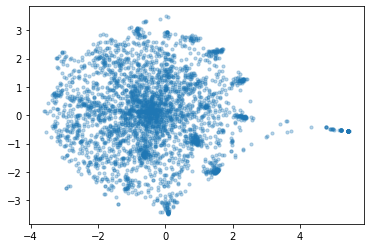

In [13]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.scatter(tsne_model[:,0], tsne_model[:,1], alpha = 0.3, s=10)
plt.show

#palette = sns.color_palette("bright", 2)
#sns.scatterplot(x=tsne_model[:,0], y=tsne_model[:,1], hue=tsne_model[:,1], legend='full')


In [14]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=30, max_iter=10000, n_init=50, random_state=42)
km.fit(tsne_model)
km.labels_


array([27, 17, 10, ..., 11, 26,  9])

In [15]:
#We will create silhouette scores to judge how good our clustering was.

from sklearn.metrics import silhouette_samples, silhouette_score

# This code was modified from Sklearn's website:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

range_n_clusters = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

for n_clusters in range_n_clusters:
    
    clusterer = KMeans(n_clusters=n_clusters, max_iter=10000, n_init = 50, random_state=42)
    cluster_labels = clusterer.fit_predict(tsne_model)
    silhouette_avg = silhouette_score(tsne_model, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(tsne_model, cluster_labels)


#Conclusion, all cluster numbers are relatively similar, 0.38 - 0.39 are not particularily impressive silhouette scores.
# (If you have distinct clusters, you will get numbers closer to 0.7+)
# 45 clusters technically has the highest score, but marginally.


For n_clusters = 5 The average silhouette_score is : 0.35377672
For n_clusters = 10 The average silhouette_score is : 0.37699968
For n_clusters = 15 The average silhouette_score is : 0.39058846
For n_clusters = 20 The average silhouette_score is : 0.4058714
For n_clusters = 25 The average silhouette_score is : 0.40347078
For n_clusters = 30 The average silhouette_score is : 0.42020634
For n_clusters = 35 The average silhouette_score is : 0.41598475
For n_clusters = 40 The average silhouette_score is : 0.40716138
For n_clusters = 45 The average silhouette_score is : 0.40728304
For n_clusters = 50 The average silhouette_score is : 0.40839595


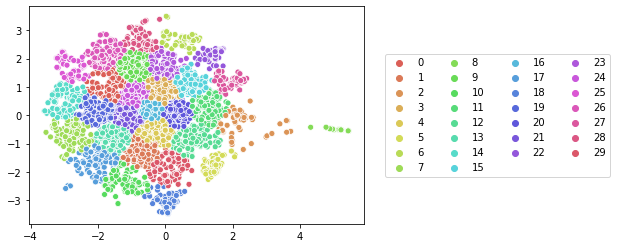

In [16]:
import seaborn as sns
from matplotlib import pyplot as plt

plot = sns.scatterplot(x=tsne_model[:,0], y=tsne_model[:,1], hue=km.labels_, 
                palette = sns.color_palette("hls", 30))
plot.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=4)


## Conclusion from t-SNE 
**Looks like a few papers stick way out.**
These are the non-English papers. This makes sense! They have very different vocabulary versus the English papers. But we still mostly wind up with a big glob in the middle. Silhouette Scores are around 0.4. We can probably do better!

## Now we will try the TruncatedSVD method

In [17]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, n_iter=100, random_state=42)
svd_model = svd.fit_transform(tfidf_matrix)
svd_model.shape

(3354, 2)

<function matplotlib.pyplot.show(*args, **kw)>

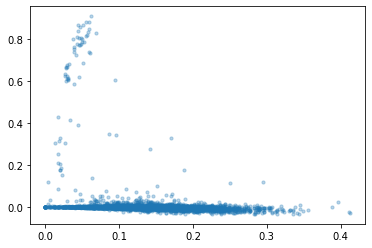

In [18]:
plt.scatter(svd_model[:,0], svd_model[:,1], alpha = 0.3, s=10)
plt.show

In [19]:
range_n_clusters = [2,3,4,5, 10, 15, 20]

for n_clusters in range_n_clusters:
    
    clusterer = KMeans(n_clusters=n_clusters, max_iter=10000, n_init = 50, random_state=42)
    cluster_labels = clusterer.fit_predict(svd_model)
    silhouette_avg = silhouette_score(svd_model, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(svd_model, cluster_labels)
    
    
    #0.896 is a really nice score!

For n_clusters = 2 The average silhouette_score is : 0.8960249202027425
For n_clusters = 3 The average silhouette_score is : 0.5322090077144154
For n_clusters = 4 The average silhouette_score is : 0.4851044879326162
For n_clusters = 5 The average silhouette_score is : 0.49519594046418197
For n_clusters = 10 The average silhouette_score is : 0.4453305559537536
For n_clusters = 15 The average silhouette_score is : 0.418128419161857
For n_clusters = 20 The average silhouette_score is : 0.3900525508631174


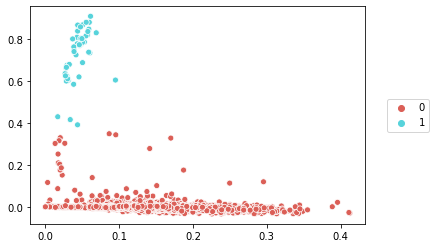

In [20]:
km = KMeans(n_clusters=2, max_iter=10000, n_init=50, random_state=42)
km.fit(svd_model)

plot = sns.scatterplot(x=svd_model[:,0], y=svd_model[:,1], hue=km.labels_, 
                palette = sns.color_palette("hls", 2))
plot.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)

#The best score is with 2 clusters. These two clusters are highly distinct, and seperate very well.
#When we take a closer look at cluster 1,
#we find it is the non-English papers. So it is doing a good job actually seperating on something meaningful!

In [21]:
#If we take a look at what's inside cluster 1...

meta_sample['k_cluster_1'] = km.labels_
meta_sample['coord1_SVD1'] = svd_model[:,0]
meta_sample['coord2_SVD1'] = svd_model[:,1]

paper_clusters = (meta_sample[['title', 'abstract', 'k_cluster_1', 'coord1_SVD1', 'coord2_SVD1']]
                  .sort_values(by=['k_cluster_1'],ascending=False))

paper_clusters[paper_clusters['k_cluster_1'] == 1]

#we find it's all Non-English papers!

,title,abstract,k_cluster_1,coord1_SVD1,coord2_SVD1
40596,Les antirétroviraux ont-ils une place dans le ...,Points essentiels L’inhibition d’une protéase ...,1,0.060191,0.735146
30687,Polyarthrite associée à une leishmaniose chez ...,"Résumé Un chien de race Cane corso, mâle, âgé ...",1,0.028798,0.667273
30709,Grippe aviaire : la menace se précise T.T. Hie...,Unknown,1,0.047807,0.804217
31293,Descompensaciones respiratorias en la enfermed...,Resumen La descompensación en la enfermedad pu...,1,0.016709,0.430026
25841,Virologie : l’apport de la biologie moléculair...,Résumé Les outils traditionnels du diagnostic ...,1,0.057511,0.836948
30593,Rationnel pour le traitement antibiotique des ...,Summary Acute bronchitis in healthy patient in...,1,0.038756,0.741412
31765,Encéphalomyélite aiguë disséminée et encéphali...,"Résumé L’encéphalomyélite aiguë disséminée, ac...",1,0.038817,0.752032
49032,Infections à Mycoplasma pneumoniae : étude rét...,Résumé But de l'étude L'objectif de cette étud...,1,0.056979,0.820378
39733,La BPCO : une maladie qui commence précocement,Résumé Cette revue générale aborde les mécanis...,1,0.042944,0.809563
48025,Tratamiento rehabilitador en la miositis aguda...,Resumen La miositis aguda benigna infantil es ...,1,0.033611,0.416349


## Conclusion from the Truncated SVD method
**We are seperating the non-English papers very well!**
We wind up with very high Silhouette scores with 2 clusters, and good scores with 3,4,and 5 clusters. What I will do next is DROP the non-English papers, and re-cluster with T-SNE to see if we can get better clusters. I think the Non-English papers are throwing my clustering off. But, still. Very cool we can seperate out non-English!

## Next, we will drop cluster 1 above, and re-cluster

In [22]:
#meta_sample_english

meta_sample_eng = meta_sample[meta_sample["k_cluster_1"] != 1]
meta_sample_eng.info()

#We wind up with 3305 items now.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3305 entries, 47449 to 13097
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cord_uid     3305 non-null   object 
 1   sha          3305 non-null   object 
 2   pmcid        2854 non-null   object 
 3   title        3305 non-null   object 
 4   abstract     3305 non-null   object 
 5   authors      3291 non-null   object 
 6   journal      3129 non-null   object 
 7   k_cluster_1  3305 non-null   int32  
 8   coord1_SVD1  3305 non-null   float64
 9   coord2_SVD1  3305 non-null   float64
dtypes: float64(2), int32(1), object(7)
memory usage: 271.1+ KB


In [23]:
#We are able to just call the methods we wrote previously to re-create clean tokens for the remaining papers.

filepaths = []
full_text_list = []
clean_text = []


findPaths(meta_sample_eng)
getFullText(filepaths)
normalizeDoc(full_text_list)



text 0 processed
text 500 processed
text 1000 processed
text 1500 processed
text 2000 processed
text 2500 processed
text 3000 processed
text 3304 processed
text 0 tokens cleaned (0.0% complete)
text 100 tokens cleaned (3.03% complete)
text 200 tokens cleaned (6.05% complete)
text 300 tokens cleaned (9.08% complete)
text 400 tokens cleaned (12.1% complete)
text 500 tokens cleaned (15.13% complete)
text 600 tokens cleaned (18.15% complete)
text 700 tokens cleaned (21.18% complete)
text 800 tokens cleaned (24.21% complete)
text 900 tokens cleaned (27.23% complete)
text 1000 tokens cleaned (30.26% complete)
text 1100 tokens cleaned (33.28% complete)
text 1200 tokens cleaned (36.31% complete)
text 1300 tokens cleaned (39.33% complete)
text 1400 tokens cleaned (42.36% complete)
text 1500 tokens cleaned (45.39% complete)
text 1600 tokens cleaned (48.41% complete)
text 1700 tokens cleaned (51.44% complete)
text 1800 tokens cleaned (54.46% complete)
text 1900 tokens cleaned (57.49% complete)
te



## Now we will re-cluster, using the same two methods as before.



In [24]:
tf = TfidfVectorizer(ngram_range=(1,2), strip_accents = 'unicode', min_df=2, max_df=0.8)
tfidf_matrix = tf.fit_transform(clean_text)
tfidf_matrix.shape

(3305, 243331)

In [25]:
#Average silhouette scores for a variety of perplexities, looking for optimal clustering

#perplex 20 and clusters 50 = 0.38836592
#perplex 25 and clusters 40 = 0.38726002
#perplex 30 and clusters 50 = 0.39350867
#perplex 35 and clusters 35 = 0.39372686
#perplex 40 and clusters 35 = 0.3945687
#perplex 50 and clusters 40 = 0.4050623 -- best so far
#perplex 60 and clusters 50 = 0.38581046
#perplex 100 and clusters 45 = 0.37500358

tsne = TSNE(perplexity = 50, verbose=1, n_iter=5000, random_state=42)
tsne_model = tsne.fit_transform(tfidf_matrix)
tsne_model.shape

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3305 samples in 0.015s...
[t-SNE] Computed neighbors for 3305 samples in 2.147s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3305
[t-SNE] Computed conditional probabilities for sample 2000 / 3305
[t-SNE] Computed conditional probabilities for sample 3000 / 3305
[t-SNE] Computed conditional probabilities for sample 3305 / 3305
[t-SNE] Mean sigma: 0.508196
[t-SNE] KL divergence after 250 iterations with early exaggeration: 169.317017
[t-SNE] KL divergence after 1450 iterations: 3.304407


(3305, 2)

<function matplotlib.pyplot.show(*args, **kw)>

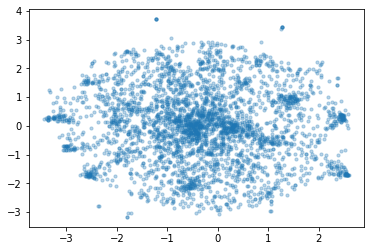

In [26]:
plt.scatter(tsne_model[:,0], tsne_model[:,1], alpha = 0.3, s=10)
plt.show

In [27]:
range_n_clusters = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, max_iter=10000, n_init = 50, random_state=42)
    cluster_labels = clusterer.fit_predict(tsne_model)
    silhouette_avg = silhouette_score(tsne_model, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(tsne_model, cluster_labels)

For n_clusters = 2 The average silhouette_score is : 0.311132
For n_clusters = 5 The average silhouette_score is : 0.3718225
For n_clusters = 10 The average silhouette_score is : 0.35913688
For n_clusters = 15 The average silhouette_score is : 0.369926
For n_clusters = 20 The average silhouette_score is : 0.39640844
For n_clusters = 25 The average silhouette_score is : 0.39141098
For n_clusters = 30 The average silhouette_score is : 0.39831585
For n_clusters = 35 The average silhouette_score is : 0.3984548
For n_clusters = 40 The average silhouette_score is : 0.4050623
For n_clusters = 45 The average silhouette_score is : 0.40297458
For n_clusters = 50 The average silhouette_score is : 0.3970124


In [28]:
svd = TruncatedSVD(n_components=2, n_iter=100, random_state=42)
svd_model = svd.fit_transform(tfidf_matrix)
svd_model.shape

(3305, 2)

<function matplotlib.pyplot.show(*args, **kw)>

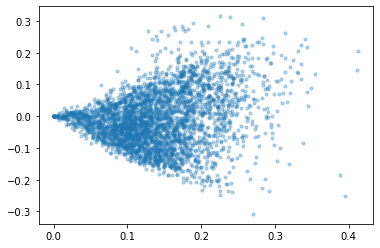

In [29]:
plt.scatter(svd_model[:,0], svd_model[:,1], alpha = 0.3, s=10)
plt.show

#Clearly it's not doing so well now. We will go with the TSNE for summarization and further analysis.

In [30]:
range_n_clusters = [2,3,4,5,10,15,20,25,30,40,50]

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, max_iter=10000, n_init = 50, random_state=42)
    cluster_labels = clusterer.fit_predict(svd_model)
    silhouette_avg = silhouette_score(svd_model, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(svd_model, cluster_labels)
    
#best is still 2 clusters.

For n_clusters = 2 The average silhouette_score is : 0.43548625437603394
For n_clusters = 3 The average silhouette_score is : 0.39109554218367587
For n_clusters = 4 The average silhouette_score is : 0.3659496007800221
For n_clusters = 5 The average silhouette_score is : 0.365238234246568
For n_clusters = 10 The average silhouette_score is : 0.3467199074495632
For n_clusters = 15 The average silhouette_score is : 0.34108649717510614
For n_clusters = 20 The average silhouette_score is : 0.3423094487306971
For n_clusters = 25 The average silhouette_score is : 0.3374024893874591
For n_clusters = 30 The average silhouette_score is : 0.33945588129315185
For n_clusters = 40 The average silhouette_score is : 0.34143006583988633
For n_clusters = 50 The average silhouette_score is : 0.34318192466227376


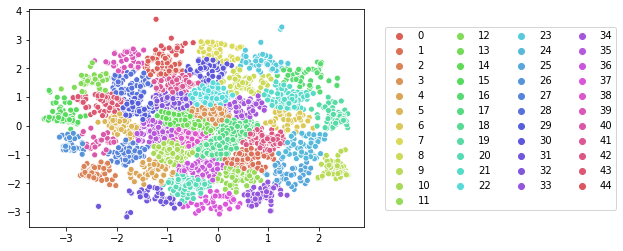

In [31]:
km_tsne = KMeans(n_clusters=45, max_iter=10000, n_init=50, random_state=42)
km_tsne.fit(tsne_model)
km_tsne.labels_

plot = sns.scatterplot(x=tsne_model[:,0], y=tsne_model[:,1], hue=km_tsne.labels_, 
                palette = sns.color_palette("hls", 45))
plot.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=4)

## Last thing I want to try is clustering just the Abstracts.

### I would expect the abstracts to cluster better, since they are a condensed version of the key content contained in each paper.

In [32]:
#I want to try and cluster the Abstracts instead, I have a feeling it will do better than the full text.


clean_text = []

abstracts = meta_sample_eng['abstract'].tolist()
normalizeDoc(abstracts)
len(clean_text)




text 0 tokens cleaned (0.0% complete)
text 100 tokens cleaned (3.03% complete)
text 200 tokens cleaned (6.05% complete)
text 300 tokens cleaned (9.08% complete)
text 400 tokens cleaned (12.1% complete)
text 500 tokens cleaned (15.13% complete)
text 600 tokens cleaned (18.15% complete)
text 700 tokens cleaned (21.18% complete)
text 800 tokens cleaned (24.21% complete)
text 900 tokens cleaned (27.23% complete)
text 1000 tokens cleaned (30.26% complete)
text 1100 tokens cleaned (33.28% complete)
text 1200 tokens cleaned (36.31% complete)
text 1300 tokens cleaned (39.33% complete)
text 1400 tokens cleaned (42.36% complete)
text 1500 tokens cleaned (45.39% complete)
text 1600 tokens cleaned (48.41% complete)
text 1700 tokens cleaned (51.44% complete)
text 1800 tokens cleaned (54.46% complete)
text 1900 tokens cleaned (57.49% complete)
text 2000 tokens cleaned (60.51% complete)
text 2100 tokens cleaned (63.54% complete)
text 2200 tokens cleaned (66.57% complete)
text 2300 tokens cleaned (69.

3305

In [33]:
clean_text[0]

'abstract gain insight genetic relationships among six canine coronavirus ccv strains variable region spike protein gene sequenced ccv strains two atcc reference strains insavc- vaccine strain national veterinary services laboratories ames ia challenge strain two california field isolates ucd- ucd-'

In [34]:
tf = TfidfVectorizer(ngram_range=(1,2), strip_accents = 'unicode', min_df=2, max_df=0.8)

#This is our vectorized data

tfidf_matrix = tf.fit_transform(clean_text)
tfidf_matrix.shape

(3305, 43093)

In [35]:
#Best conditions so far:

#perplex 20 clusters 50 = 0.38977432
#perplex 30 clusters 35 = 0.39461362 --best so far
#perplex 40 clusters 35 = 0.38261372


tsne = TSNE(perplexity = 30, verbose=1, n_iter=5000, random_state=42)
tsne_model = tsne.fit_transform(tfidf_matrix)
tsne_model.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3305 samples in 0.003s...
[t-SNE] Computed neighbors for 3305 samples in 0.768s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3305
[t-SNE] Computed conditional probabilities for sample 2000 / 3305
[t-SNE] Computed conditional probabilities for sample 3000 / 3305
[t-SNE] Computed conditional probabilities for sample 3305 / 3305
[t-SNE] Mean sigma: 0.502429
[t-SNE] KL divergence after 250 iterations with early exaggeration: 181.153244
[t-SNE] KL divergence after 1300 iterations: 3.843317


(3305, 2)

<function matplotlib.pyplot.show(*args, **kw)>

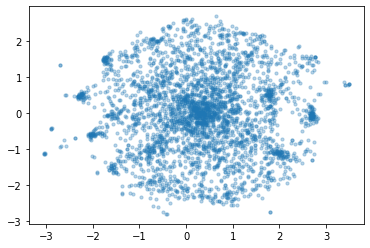

In [36]:
plt.scatter(tsne_model[:,0], tsne_model[:,1], alpha = 0.3, s=10)
plt.show

In [37]:
range_n_clusters = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, max_iter=10000, n_init = 50, random_state=42)
    cluster_labels = clusterer.fit_predict(tsne_model)
    silhouette_avg = silhouette_score(tsne_model, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(tsne_model, cluster_labels)

For n_clusters = 2 The average silhouette_score is : 0.297098
For n_clusters = 5 The average silhouette_score is : 0.3686403
For n_clusters = 10 The average silhouette_score is : 0.34570652
For n_clusters = 15 The average silhouette_score is : 0.3742907
For n_clusters = 20 The average silhouette_score is : 0.37275293
For n_clusters = 25 The average silhouette_score is : 0.3867381
For n_clusters = 30 The average silhouette_score is : 0.39198738
For n_clusters = 35 The average silhouette_score is : 0.39461362
For n_clusters = 40 The average silhouette_score is : 0.38914827
For n_clusters = 45 The average silhouette_score is : 0.38620743
For n_clusters = 50 The average silhouette_score is : 0.3874608


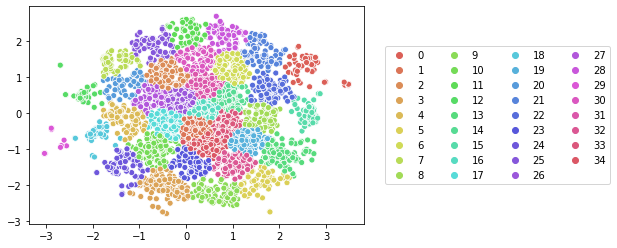

In [38]:
km_tsne = KMeans(n_clusters=35, max_iter=10000, n_init=50, random_state=42)
km_tsne.fit(tsne_model)
km_tsne.labels_

plot = sns.scatterplot(x=tsne_model[:,0], y=tsne_model[:,1], hue=km_tsne.labels_, 
                palette = sns.color_palette("hls", 35))
plot.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=4)


Looks like the Abstracts do just the same as the full text. There are distinct clusters around the edges, and clusters on opposite sides of the map are probably quite different. Still a large blob in the middle. Probably tf-IDF isn't sensitive enough to detect more subtle changes. Or perhaps we were too aggressive cleaning our tokens, our perhaps not aggressive enough. Either way, we will go with it! It's doing a decent job now. 

This is an especially difficult clustering task because the content of ALL the papers has something to do with infectious disease, so perhaps the differences are too subtle for tf-idf.


# Now we will summarize the documents within each cluster and write the summary to a file.


In [39]:
#To do this next part, we need SENTENCES from our meta_sample_eng texts.
#But first things first, append the cluster number to our meta_sample_eng dataframe.
pd.options.mode.chained_assignment = None

meta_sample_eng['k_cluster_2'] = km_tsne.labels_
meta_sample_eng['coord1_TSNE2'] = tsne_model[:,0]
meta_sample_eng['coord2_TSNE2'] = tsne_model[:,1]

from nltk.tokenize import sent_tokenize
#We need to remove all 'et al.' , 'fig.' , 'Fig.'  the sentence tokenizer thinks it is the end of a sentence.
#We can go ahead and remove stopwords as well.

stop_words = nltk.corpus.stopwords.words('english')
#extraStopWords = ['et','al', 'al.']
#stop_words.extend(extraStopWords)

full_clean_text = []
for i in range(0,len(full_text_list)):
    full_text_list[i] = re.sub(r'et al.', '', full_text_list[i], re.I)
    full_text_list[i] = re.sub(r'fig.', 'fig', full_text_list[i], re.I)
    
    
    full_text_list[i] = full_text_list[i].lower()
    full_text_list[i] = full_text_list[i].strip()
    tokens = nltk.sent_tokenize(full_text_list[i])
    clean_sents = [t for t in tokens if t not in stop_words]        

    #clean_text.append(' '.join(clean_sents))
    
    full_clean_text.append(clean_sents)

meta_sample_eng['full_clean_text'] = full_clean_text

#I don't really need the k_cluster_1 and the coord1, coord2 anymore. I'll drop them now.
meta_sample_eng = meta_sample_eng[['cord_uid','sha', 'pmcid','title','abstract','authors','journal', 'full_clean_text','k_cluster_2','coord1_TSNE2', 'coord2_TSNE2']]

## I tried Summarizing with the full text above, it is WAY TOO SLOW!!

# I will need to re-try this with just the Abstracts to improve the speed.

In [40]:
#OK, I tried Summarizing with the full text above, it is WAY TOO SLOW!!

# I will need to re-try this with just the Abstracts to improve the speed.
pd.options.mode.chained_assignment = None

meta_sample_eng['k_cluster_2'] = km_tsne.labels_
meta_sample_eng['coord1_TSNE2'] = tsne_model[:,0]
meta_sample_eng['coord2_TSNE2'] = tsne_model[:,1]
from nltk.tokenize import sent_tokenize
stop_words = nltk.corpus.stopwords.words('english')
full_clean_abstracts = []
abstracts = meta_sample_eng['abstract'].tolist()

for i in range(0,len(abstracts)):
    abstracts[i] = abstracts[i].lower()
    abstracts[i] = re.sub(r'et al.', '', abstracts[i], re.I)
    abstracts[i] = re.sub(r'fig.', 'fig', abstracts[i], re.I)
    abstracts[i] = re.sub(r':', '', abstracts[i], re.I)
    abstracts[i] = re.sub(r'abstract[s]?', '', abstracts[i], re.I)   
    abstracts[i] = re.sub(r'summary', '', abstracts[i], re.I)
    abstracts[i] = re.sub(r'objective[s]?', '', abstracts[i], re.I)
    abstracts[i] = re.sub(r'result[s]?', '', abstracts[i], re.I)
    abstracts[i] = re.sub(r'method[s]?', '', abstracts[i], re.I)
    abstracts[i] = re.sub(r'conclusion[s]?', '', abstracts[i], re.I)
    abstracts[i] = re.sub(r'background', '', abstracts[i], re.I)
    abstracts[i] = re.sub(r'stud[y]?[i]?[e]?[s]?', '', abstracts[i], re.I)
    abstracts[i] = abstracts[i].strip()
    tokens = nltk.sent_tokenize( abstracts[i])
    clean_sents = [t for t in tokens if t not in stop_words]
    
    #clean_text.append(' '.join(clean_sents))
    
    full_clean_abstracts.append(clean_sents)

meta_sample_eng['full_clean_abstracts'] = full_clean_abstracts

#I don't really need the k_cluster_1 and the coord1, coord2 anymore. I'll drop them now.
meta_sample_eng = meta_sample_eng[['cord_uid','sha', 'pmcid','title','abstract','authors','journal', 'full_clean_abstracts','k_cluster_2','coord1_TSNE2', 'coord2_TSNE2']]



In [41]:
#This block takes a LONG time. User beware. Not so bad with the Abstracts though.

import networkx
pd.options.mode.chained_assignment = None  #This supresses a chained assignment warning caused by assigning a new column to a
#copy of the original dataframe. I don't intend to keep using myClusterDf after it serves its purpose, so it's fine.

tf = TfidfVectorizer(ngram_range=(1,2), strip_accents = 'ascii', min_df=2, max_df=0.8)
percentDocsToSummarizeInEachCluster = 1

for i in range(0,len(km_tsne.cluster_centers_)):
    
    myClusterDf = meta_sample_eng[meta_sample_eng['k_cluster_2'] == i]

    mycoord1 = meta_sample_eng[meta_sample_eng['k_cluster_2'] == i]['coord1_TSNE2']
    mycoord2 = meta_sample_eng[meta_sample_eng['k_cluster_2'] == i]['coord2_TSNE2']

    distance_list = []
    for j in range(0,len(meta_sample_eng[meta_sample_eng['k_cluster_2'] == i])):
        distance = math.sqrt((km_tsne.cluster_centers_[i][0] - mycoord1.iloc[j])**2 + (km_tsne.cluster_centers_[i][1] - mycoord2.iloc[j])**2)
        distance_list.append(distance)

    myClusterDf['distance'] = distance_list

    myClusterDf = myClusterDf.sort_values(by=['distance'])
    numToSummarize = round(percentDocsToSummarizeInEachCluster * len(myClusterDf))
    myClusterDf = myClusterDf[:numToSummarize] #Ok it works, got the top 10% of closest (smallest distance) papers to cluster center 0.

    cluster_sentences = []

    for s in myClusterDf['full_clean_abstracts']:
      cluster_sentences.append(s)

    cluster_sentences = [y for x in cluster_sentences for y in x] # flatten list
    
    
    tfidf_matrix = tf.fit_transform(cluster_sentences)
    tfidf_matrix.toarray()
    tfTranspose = tfidf_matrix.T.toarray()
    similarity_matrix = tfidf_matrix * tfTranspose
    

    similarity_graph = networkx.from_numpy_array(similarity_matrix)
    scores = networkx.pagerank(similarity_graph)
    ranked_sentences = sorted(((score, index) for index, score in scores.items()),reverse=True)
    
    top_sentence_indices = [ranked_sentences[index][1] for index in range(0,5)]
    top_sentence_indices.sort()

    # construct the document summary
    documentID = "cluster summary.txt"


    if i == 0:
        with open(documentID, "w+", encoding="utf-8") as file:
            file.write("Cluster " + str(i) + " Summary: \n")
            file.write('\n\n'.join(np.array(cluster_sentences)[top_sentence_indices]))
            file.write('\n\n\n')
            file.close()
    else:
        with open(documentID, "a+", encoding="utf-8") as file:
            file.write("Cluster " + str(i) + " Summary: \n")
            file.write('\n\n'.join(np.array(cluster_sentences)[top_sentence_indices]))
            file.write('\n\n\n')
            file.close()
            
    print("Cluster " + str(i) + " successfully summarized. (" + str(round((i+1)/len(km_tsne.cluster_centers_)*100, ndigits=2)) + "% complete)")

Cluster 0 successfully summarized. (2.86% complete)
Cluster 1 successfully summarized. (5.71% complete)
Cluster 2 successfully summarized. (8.57% complete)
Cluster 3 successfully summarized. (11.43% complete)
Cluster 4 successfully summarized. (14.29% complete)
Cluster 5 successfully summarized. (17.14% complete)
Cluster 6 successfully summarized. (20.0% complete)
Cluster 7 successfully summarized. (22.86% complete)
Cluster 8 successfully summarized. (25.71% complete)
Cluster 9 successfully summarized. (28.57% complete)
Cluster 10 successfully summarized. (31.43% complete)
Cluster 11 successfully summarized. (34.29% complete)
Cluster 12 successfully summarized. (37.14% complete)
Cluster 13 successfully summarized. (40.0% complete)
Cluster 14 successfully summarized. (42.86% complete)
Cluster 15 successfully summarized. (45.71% complete)
Cluster 16 successfully summarized. (48.57% complete)
Cluster 17 successfully summarized. (51.43% complete)
Cluster 18 successfully summarized. (54.29%